In [0]:
# data analysis for MUSIC data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import savetxt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

# extra added for using inbuilt sigmoid

from scipy.special import expit

In [0]:
op_cases = 4
train_df = pd.read_csv("TrainData4.csv")
data_t = train_df.to_numpy()
x_train = data_t[:,1:29]
y_train = data_t[:,29:33]

val_df = pd.read_csv("ValData4.csv")
data_v = val_df.to_numpy()
x_val = data_v[:,1:29]
y_val = data_v[:,29:33]

test_df = pd.read_csv("TestData4.csv")
data_te = test_df.to_numpy()
x_test = data_te[:,1:29]
y_test = data_te[:,29:33]

In [4]:
print(x_train.shape)

(240, 28)


In [0]:
def sigmoidGrad(z):
    return expit(z)*(1-expit(z))

In [0]:
def tanh(z):
    return (2*expit(z) - 1)

In [0]:
def softmax(z):
    t = np.exp(z - np.max(z,axis=0))
    return t / np.sum(t,axis=0)

In [0]:
def softmaxGrad(z):
    return softmax(z)*(1-softmax(z))

In [0]:
def relu(z):
    return z*(z>0)

In [0]:
# cost function for 1 hidden layer Neural Network
def cost_function_NN1(theta,hlSize,numLabel,X,y,lam=0):
    m= X.shape[0]
    ipSize = X.shape[1]
    J=0

    t1 = theta[0:hlSize*(ipSize +1)].reshape(hlSize,ipSize+1)
    t2 = theta[hlSize*(ipSize +1) : (hlSize*(ipSize +1)) + (numLabel*(hlSize +1))].reshape(numLabel,hlSize+1)

    tGrad1 = np.zeros(t1.shape)
    tGrad2 = np.zeros(t2.shape)
    #print(X.shape,t1.shape)
    # Forward propogation algorithm
    z2 = np.append(np.ones((m,1)),X,axis =1).dot(t1.T)
    a2 = expit(z2)
    z3 = np.append(np.ones((m,1)),a2,axis=1).dot(t2.T)
    a3 = expit(z3)
    h = a3
    J = (-1/m)*np.sum( y*np.log(h + 1e-20) + (1-y)*np.log(1-h + 1e-20)) 
    #Reg = 
    
    # Back propogation algorithm
    D2=np.zeros(t2.shape)
    D1=np.zeros(t1.shape)
    err3 = h - y

    l = t2.shape[1]
    
    err2 = (err3.dot(t2[:,1:l])) * sigmoidGrad(z2) 
    
    for i in range(m):
        D2 = D2 + (err3[i:i+1,:].T).dot(np.append(np.ones((1,1)),a2[i:i+1,:],axis=1))
        D1 = D1 + (err2[i:i+1,:].T).dot(np.append(np.ones((1,1)),X[i:i+1,:],axis=1))
    tGrad1 = D1/m
    #tGrad1[:,1:tGrad1.shape[1]] = tGrad1[:,1:tGrad1.shape[1]] + lam/m*t1[:,1:t1.shape[1]]
    tGrad2 = D2/m
    #tGrad2[:,1:tGrad2.shape[1]] = tGrad2[:,1:tGrad2.shape[1]] + lam/m*t2[:,1:t2.shape[1]]

    #print(tGrad1, tGrad2)
    grad = np.concatenate([tGrad1.flat, tGrad2.flat])
    
    #print(grad.shape)
    return [J,grad,h]

In [0]:
# gradient descent algorithm for 1 hidden layer NN
def gradient_descent_NN1(X,y,theta,lam,max_itr,alpha,hlSize): # without regularisation !
    m=X.shape[0]
    J_hist=np.zeros((max_itr,1))
    
    numLabel = y.shape[1]
    for i in range(max_itr):
        [J,grad,h]=cost_function_NN1(theta, hlSize, numLabel, X, y, lam)
        if i%1000==0:
          print(i)
        #if i==12000:
        #  alpha = alpha /1.5
        theta = theta - (alpha)*(grad) 
        J_hist[i]=J
    return [theta,J_hist]

In [0]:
# check if gradien found from back propogation is correct
def gradient_check_NN1(theta,hlSize,numLabel,X,y):
    #m= X.shape[0]
    #ipSize = X.shape[1]
    appGrad = np.zeros(theta.shape)

    #t1 = theta[0:hlSize*(ipSize +1)].reshape(hlSize,ipSize+1)
    #t2 = theta[hlSize*(ipSize +1) : (hlSize*(ipSize +1)) + (numLabel*(hlSize +1))+1].reshape(numLabel,hlSize+1)

    #tGrad1 = np.zeros(t1.shape)
    #tGrad2 = np.zeros(t2.shape)
    epsilon =.0001
    
    for i in range(theta.shape[0]):
        posTheta = theta
        posTheta[i:i+1] = posTheta[i:i+1] + epsilon
        posJ,gr,h = cost_function_NN1(posTheta, hlSize, numLabel, X, y)
        negTheta = theta
        negTheta[i:i+1] = negTheta[i:i+1] - epsilon
        negJ,gr,h = cost_function_NN1(negTheta, hlSize, numLabel, X, y)
        appGrad[i:i+1]=((posJ-negJ)/(2*epsilon))
        
    print(posJ,negJ)
    return appGrad

In [0]:
def prediction(h,y):
    count =0
    h_out = np.zeros(h.shape)
    
    for i in range(h.shape[0]):
        if h.shape[1] == 1:
            if h[i] >= 0.5:
                h_out[i] = 1
        else:
            h_out[i, np.argmax(h[i,:])] =1
    
    
    for i in range(h.shape[0]):
        for j in range(h.shape[1]):
            if h_out[i,j]!=y[i,j]:
                count = count+1
                break
    acc = (h.shape[0] - count)/h.shape[0] *100
    return [h_out, acc]


In [0]:
ipSize = x_train.shape[1]
hlSize = 17 
numLabel = y_train.shape[1]
E0= 0.1
itheta1 = np.random.randint(1,10,(hlSize,ipSize+1))
itheta1 = itheta1*2*E0 - E0
itheta2 = np.random.randint(1,10,(numLabel,hlSize+1))
itheta2 = itheta2*2*E0 - E0
initial_theta = np.concatenate([itheta1.flat, itheta2.flat])

In [0]:
lam =0
alpha =1.07
max_itr = 30000


In [0]:

J,grad,h = cost_function_NN1(initial_theta, hlSize, numLabel, x_train, y_train)

appGrad = gradient_check_NN1(initial_theta, hlSize, numLabel, x_train, y_train)
for i in range(grad.shape[0]):
    print("{}   {}      {}".format(grad[i],appGrad[i],i))

In [0]:
print(h)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


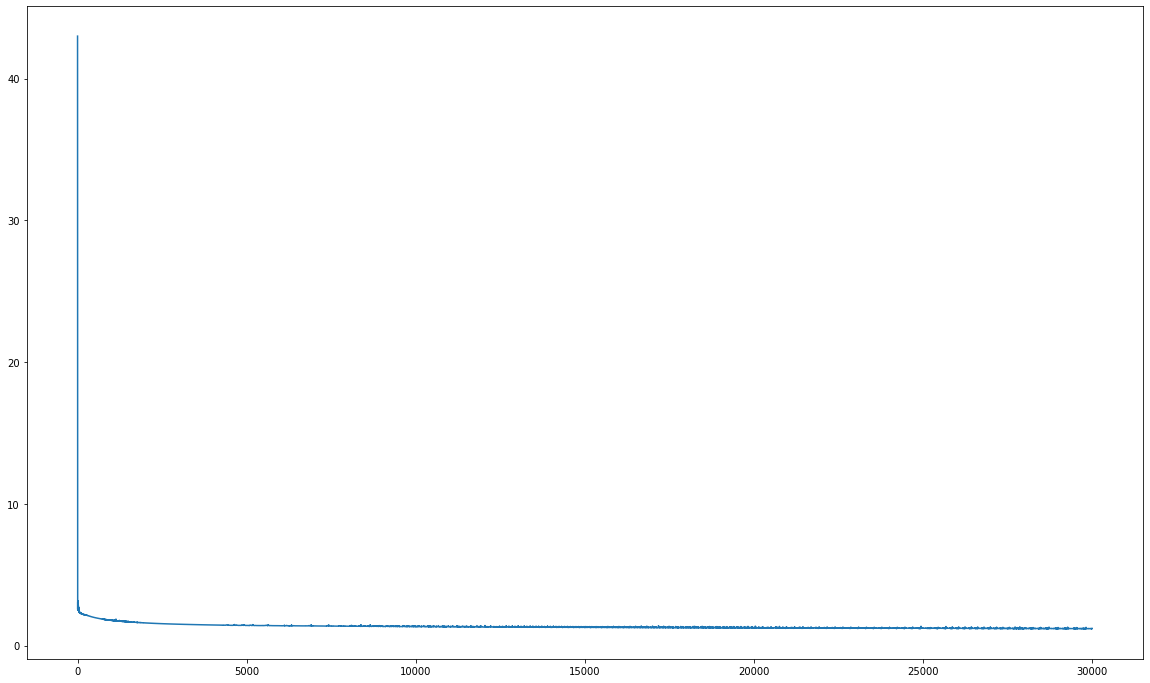

1.2232084481136467

accuracy (train):   69.16666666666667

accuracy:   60.0
[0. 1. 0. 0.]      [0. 1. 0. 0.] 
[0. 0. 1. 0.]      [0. 0. 0. 1.] 
[0. 0. 1. 0.]      [0. 0. 1. 0.] 
[0. 1. 0. 0.]      [0. 1. 0. 0.] 
[0. 0. 1. 0.]      [0. 0. 0. 1.] 
[0. 0. 1. 0.]      [0. 0. 1. 0.] 
[0. 0. 1. 0.]      [0. 0. 0. 1.] 
[0. 0. 0. 1.]      [0. 0. 0. 1.] 
[0. 0. 1. 0.]      [0. 0. 1. 0.] 
[0. 1. 0. 0.]      [0. 1. 0. 0.] 
[0. 0. 0. 1.]      [0. 0. 1. 0.] 
[0. 0. 0. 1.]      [1. 0. 0. 0.] 
[1. 0. 0. 0.]      [1. 0. 0. 0.] 
[0. 0. 1. 0.]      [1. 0. 0. 0.] 
[0. 0. 1. 0.]      [0. 0. 0. 1.] 
[0. 0. 1. 0.]      [0. 0. 1. 0.] 
[0. 1. 0. 0.]      [0. 1. 0. 0.] 
[0. 0. 1. 0.]      [0. 0. 1. 0.] 
[1. 0. 0. 0.]      [1. 0. 0. 0.] 
[0. 0. 0. 1.]      [0. 0. 1. 0.] 
[0. 0. 0. 1.]      [1. 0. 0. 0.] 
[0. 0. 0. 1.]      [0. 0. 0. 1.] 
[0. 0. 0. 1.]      [0. 0. 0. 1.] 
[0. 1. 0. 0.]      [0. 1. 0. 0.] 
[0. 0. 1. 0.]      [1. 0. 0. 0.] 
[0. 1. 0. 0.]      [0. 1. 0. 0.] 
[0. 1. 0. 0.]      [0. 1. 0. 0.] 
[0. 0.

In [28]:
theta,J_hist = gradient_descent_NN1(x_train, y_train, initial_theta, lam, max_itr, alpha, hlSize)
i=np.arange(1,30001,1) 
plt.plot(i,J_hist)
plt.show()  
print(J_hist[29998,0])
#learning_curve(hlSize,numLabel,x_train, x_val, y_train, y_val, theta, lam)

[J,grad,h_train]=cost_function_NN1(theta, hlSize, numLabel, x_train, y_train)
h_train,acc=prediction(h_train,y_train)
print("\naccuracy (train):  ",acc)

[J,grad,h_test]=cost_function_NN1(theta, hlSize, numLabel, x_test, y_test)
h_test,acc=prediction(h_test,y_test)
print("\naccuracy:  ",acc)    
for i in range(y_test.shape[0]):
    print( "{}      {} " .format(h_test[i] , y_test[i]))

In [24]:
print(J_hist[29998,0])

1.1985099475536154


In [0]:
for i in range(theta.shape[0]):
  print(initial_theta[i],"  ",theta[i])


In [0]:
testAcc_hist = np.zeros((10,1))
trainAcc_hist = np.zeros((10,1))

In [0]:
to check best possible hidden layer size

for i in range(10):
  hlSize = (i+1)*4
  E0= 0.01
  itheta1 = np.random.randint(1,10,(hlSize,ipSize+1))
  itheta1 = itheta1*2*E0 - E0
  itheta2 = np.random.randint(1,10,(numLabel,hlSize+1))
  itheta2 = itheta2*2*E0 - E0
  initial_theta = np.concatenate([itheta1.flat, itheta2.flat])

  theta,J_hist = gradient_descent_NN1(x_train, y_train, initial_theta, lam, max_itr, alpha, hlSize)
  j=np.arange(1,1001,1) 
  plt.plot(j,J_hist)
  plt.show()  

  #learning_curve(hlSize,numLabel,x_train, x_val, y_train, y_val, theta, lam)

  [J,grad,h_train]=cost_function_NN1(theta, hlSize, numLabel, x_train, y_train)
  h_train,acc=prediction(h_train,y_train)
  print("\naccuracy (train):  ",acc)
  trainAcc_hist[i] = acc
  [J,grad,h_test]=cost_function_NN1(theta, hlSize, numLabel, x_test, y_test)
  h_test,acc=prediction(h_test,y_test)
  print("\naccuracy:  ",acc)    
  testAcc_hist[i] = acc
  #for i in range(y_test.shape[0]):
      #print( "{}      {} " .format(h_test[i] , y_test[i]))

In [0]:
i=np.arange(1,11,1)
plt.plot(i,trainAcc_hist)
plt.show()

plt.plot(i,testAcc_hist)
plt.show()